In [13]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

import analysis_functions

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

Import the dataframes: 

In [14]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
data_rel = pd.read_csv('data/Chloroplasts_removed/nochloro_relative_otu.tsv', sep=' ', index_col=None, header=0)
target = pd.read_csv('data/Chloroplasts_removed/nochloro_HNA_LNA.tsv', sep=' ', index_col=0, header=0)
productivity = pd.read_csv('data/Chloroplasts_removed/productivity_data.tsv', sep=' ', index_col=0, header=0)

In [15]:
'''Set sample names as index and shuffle data'''
data_abs.set_index(target.index,inplace=True)
data_rel.set_index(target.index,inplace=True)
productivity.set_index(target.index,inplace=True)
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
productivity = productivity.sample(frac=1, random_state=3)

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna_rel.index)

**Preprocessing of data**: filter out those OTUs which have very low abundances and so give rise to (almost) zero-columns. Therefore an OTU has to have a minimal relative abundance one, defined by the parameter _abun_. However, I use a **second constraint** which states that an OTU must have a relative abundance > _abun_ in one of the **productivity** samples. In this way we're going to bias the OTU-selection towards the ones present in the productivity samples. 

In [16]:
from sklearn.linear_model import LinearRegression
from analysis_functions import get_r2
from scipy.stats import linregress

#retain only productivity samples 
productivity = productivity.dropna(subset=['tot_bacprod'])
idx_prod = productivity.index.values
prod = pd.Series(productivity.tot_bacprod.values, index=idx_prod)
prod_error = pd.Series(productivity.SD_tot_bacprod.values, index=idx_prod)
prod_rel_error = prod_error/prod

In [17]:
abun = 0.0075

In [18]:
from analysis_functions import preprocess_df
data_abs_prod = data_abs.loc[idx_prod,:] 
data_abs_prod = preprocess_df(data_abs_prod,abun,True)
otus_prod = list(data_abs_prod.columns)

print('Number of OTUs: ' + str(len(otus_prod)))

Number of OTUs: 97


Let's see how well these OTU's perform in a 4x5 nested Lasso: 

In [19]:
from analysis_functions import perform_nested_lasso_cv
from analysis_functions import get_r2
alphas_abs, preds_abs = perform_nested_lasso_cv(data_abs[otus_prod], hna)
alphas_rel, preds_rel = perform_nested_lasso_cv(data_rel[otus_prod], hna)

r2_abs = get_r2(hna, preds_abs)
r2_rel = get_r2(hna, preds_rel)

print('R2 based on absolute abundances: ' + str(r2_abs))
print('R2 based on relative abundances: ' + str(r2_rel))

R2 based on absolute abundances: 0.8181522281
R2 based on relative abundances: 0.582425497273


The $R^2$ still is reasonable, especially when we use absolute abundances. Let's again determine the most important OTU's based on the randomized Lasso: 

In [20]:
from analysis_functions import perform_randomizedLasso

otus_prod_scores = pd.Series(perform_randomizedLasso(data_abs[otus_prod], hna, alphas_abs.mean()), index=otus_prod)
otus_prod_scores.sort_values(ascending=False,inplace=True)

#Display top 20 OTUs:
display(otus_prod_scores.head(20))

Otu000005    1.000
Otu000057    1.000
Otu000004    0.998
Otu000016    0.964
Otu000027    0.956
Otu000042    0.956
Otu000010    0.932
Otu000084    0.930
Otu000041    0.900
Otu000058    0.880
Otu000047    0.834
Otu000022    0.822
Otu000012    0.786
Otu000038    0.780
Otu000009    0.764
Otu000006    0.762
Otu000029    0.692
Otu000025    0.686
Otu000001    0.678
Otu000011    0.676
dtype: float64

Let's see what happens if we tune the threshold value for these scores: 

In [21]:
from analysis_functions import perform_nested_ridge_cv

thresholds = np.arange(0,1,0.02)
r2_scores = np.zeros(len(thresholds))
dummy=0

#Make copy of otu_scores to be able to rerun analysis: 
scores = otus_prod_scores
for thresh in thresholds: 
    scores = otus_prod_scores[otus_prod_scores.values > thresh]
    features_new = scores.index
    if(len(features_new) > 0): 
        alphas, preds = perform_nested_ridge_cv(data_abs[features_new],hna)
        #alphas, preds = perform_nested_lasso_cv(data_abs[features_new],hna)
        r2_scores[dummy] = get_r2(hna,preds)
    dummy+=1

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


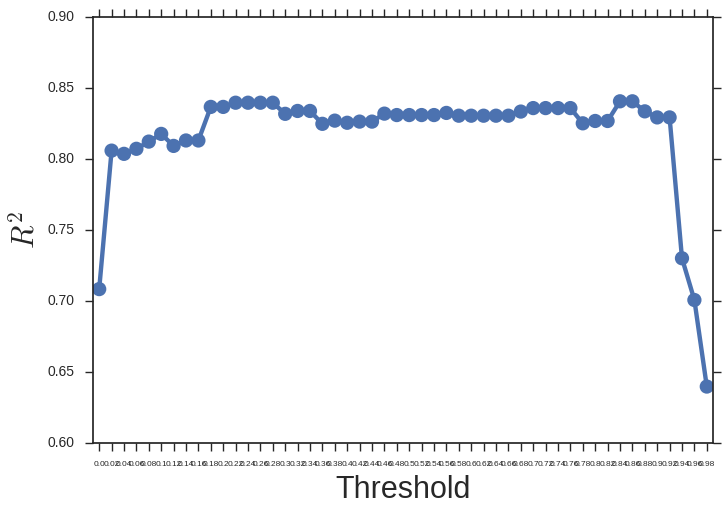

In [22]:
plt.figure()
sns.pointplot(thresholds,r2_scores, scatter_kws={"s": 0.7})
plt.xlabel('Threshold', size=22)
plt.xticks(size=6)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.show()

Choose the value for which the $R^2$ is maximal: 

In [23]:
r2_max = r2_scores.max()
r2_max_idx = r2_scores.argmax()
thresh_max = thresholds[r2_max_idx]
print('R2 max = ' + str(r2_max))
print('Optimal threshold = ' + str(thresh_max))

R2 max = 0.84048933381
Optimal threshold = 0.84


In [24]:
optimal_scores = otus_prod_scores[otus_prod_scores.values>thresh_max]
selected_otus = optimal_scores.index
print('Number of selected OTUs: ' + str(len(selected_otus)))

alphas_opt, preds_opt = perform_nested_lasso_cv(data_abs[selected_otus], hna)
r2_final = get_r2(hna, preds_opt)
print('r2: ' + str(r2_final))

from analysis_functions import get_r2_adj
r2_adj = get_r2_adj(r2_final, data_abs.shape[0], len(selected_otus))
print('r2_adj: ' + str(r2_adj))

Number of selected OTUs: 10
r2: 0.8389423743
r2_adj: 0.829000545553


This result is quite good, the $R^2$ is of course lower than using an initial filtering based on all samples, but only retaining those OTU's which are significantly present in the productivity samples results in an $R^2_{adj} = 0.829$! Moreover, we are left with **10 OTU's**. 

However, we can perform the same analysis to find the optimal threshold, but instead of using the $R^2$ between HNA and the predicted HNA, we can calculate the $R^2$ of the linear regression between the predicted HNA and the productivity, as this has an initial $R^2$ of roughly 0.6: 

In [25]:
thresholds = np.arange(0,1,0.02)
r2_scores = np.zeros(len(thresholds))
dummy=0

#Make copy of otu_scores to be able to rerun analysis: 
scores = otus_prod_scores
for thresh in thresholds: 
    scores = otus_prod_scores[otus_prod_scores.values > thresh]
#scores_nested_mean = scores_nested_mean[scores_nested_mean > 0.16]
    features_new = scores.index
    if(len(features_new) > 0): 
        #alphas, preds = perform_nested_ridge_cv(data_abs[features_new],hna)
        alphas, preds = perform_nested_lasso_cv(data_abs[features_new],hna)
        #Check the R2 of the linear regression between the HNA-predictions and productivity 
        r2_scores[dummy] = linregress(prod[idx_prod],preds[idx_prod])[2]**2
    dummy+=1

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


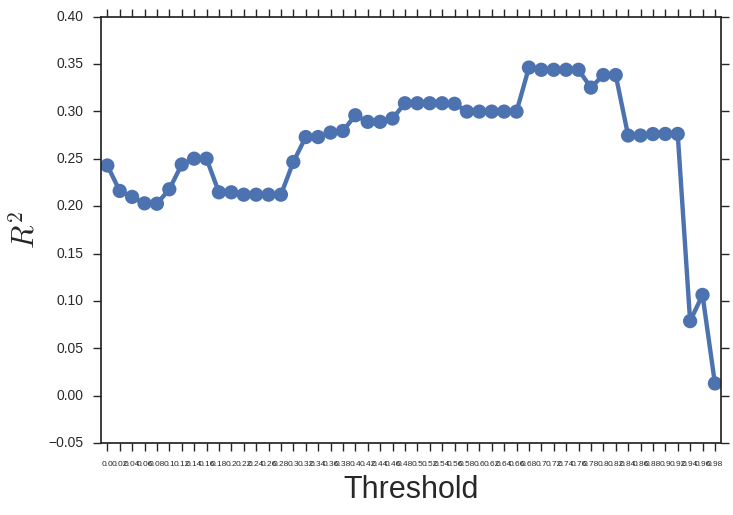

In [26]:
plt.figure()
sns.pointplot(thresholds,r2_scores, scatter_kws={"s": 0.7})
plt.xlabel('Threshold', size=22)
plt.xticks(size=6)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.show()

Again, let's select the optimal threshold for the scores: 

In [27]:
r2_max = r2_scores.max()
r2_max_idx = r2_scores.argmax()
thresh_max = thresholds[r2_max_idx]
print('R2 max = ' + str(r2_max))
print('Optimal threshold = ' + str(thresh_max))

R2 max = 0.346338366374
Optimal threshold = 0.68


In [28]:
optimal_scores = otus_prod_scores[otus_prod_scores.values>thresh_max]
selected_otus = optimal_scores.index
print('Number of selected OTUs: ' + str(len(selected_otus)))

r2_adj = get_r2_adj(r2_max, prod.shape[0], len(selected_otus))
print('r2_adj: ' + str(r2_adj))

Number of selected OTUs: 18
r2_adj: -2.59513898495


This gives us **13 OTU's** which is also quite a good result; however, the $R^2_{adj}$  = -0.191, because of the low sample size. Can we use these OTU's directly to predict the productivity? For this purpose I use again a nested cross-validation scheme, however, I use a leave-one-out (loocv) approach in order to get an estimate: 

R2 productivity: 0.14191025957


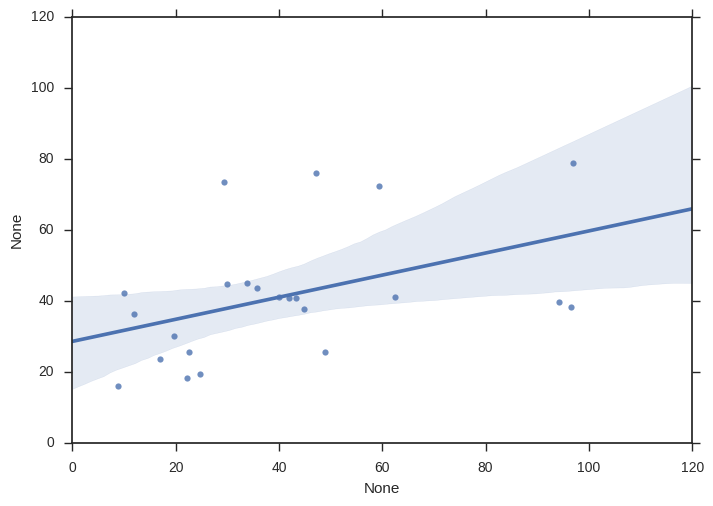

In [29]:
from analysis_functions import perform_nested_lasso_loocv
alphas, preds = perform_nested_lasso_loocv(data_abs.loc[idx_prod,selected_otus], prod)

print('R2 productivity: ' + str(str(get_r2(prod, preds))))

plt.figure()
sns.regplot(prod, preds)
plt.show()

This doesn't look good; probably due to the low sample size. What we can do is look at the mutual correlation between the top-OTU's and the production: 

In [30]:
optimal_scores = pd.DataFrame(optimal_scores, index=selected_otus)
r = np.zeros(len(selected_otus))
t = 0
for otu in selected_otus: 
    r[t] = linregress(prod,data_abs.loc[idx_prod,otu])[2]
    t+=1
optimal_scores['correlation'] = r
optimal_scores['adj_r2'] = get_r2_adj(r**2, len(selected_otus), 1)
display(optimal_scores)
    

,0,correlation,adj_r2
Otu000005,1.000,0.064389,-0.058095
Otu000057,1.000,0.189438,-0.024370
Otu000004,0.998,-0.121613,-0.046786
Otu000016,0.964,0.376786,0.088341
Otu000027,0.956,0.056837,-0.059068
Otu000042,0.956,-0.063374,-0.058233
Otu000010,0.932,0.216380,-0.012753
Otu000084,0.930,0.588292,0.305218
Otu000041,0.900,-0.453394,0.155914
Otu000058,0.880,0.097805,-0.052336


Let's visualize OTU000057, OTU000084, OTU000041 and OTU000022: 

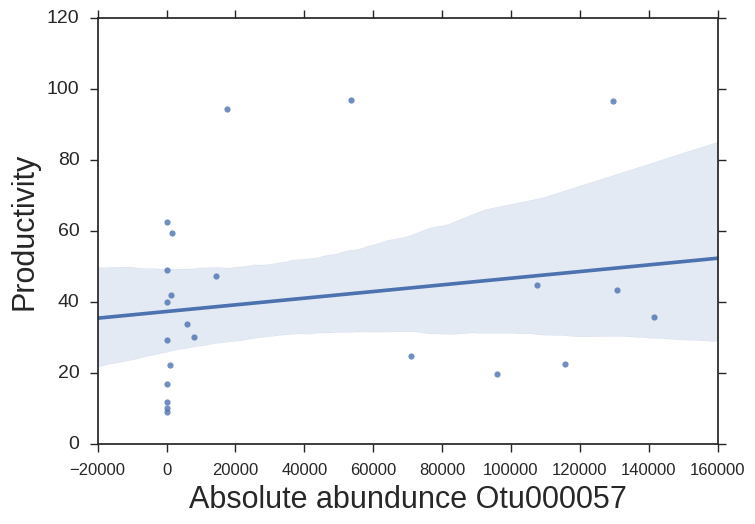

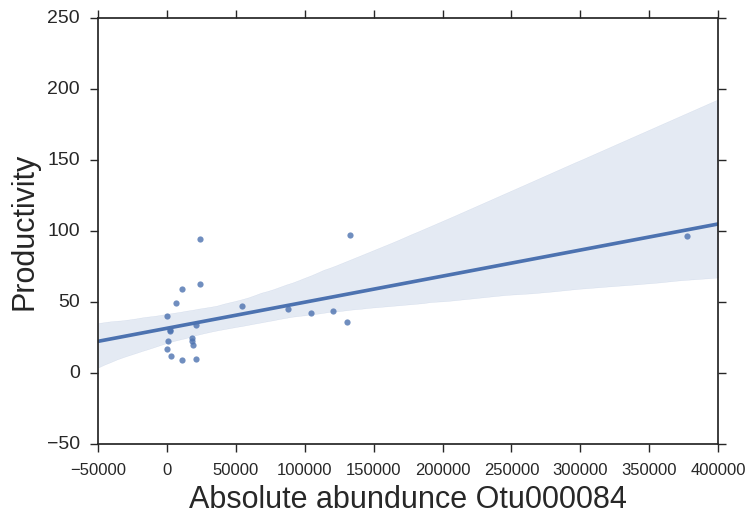

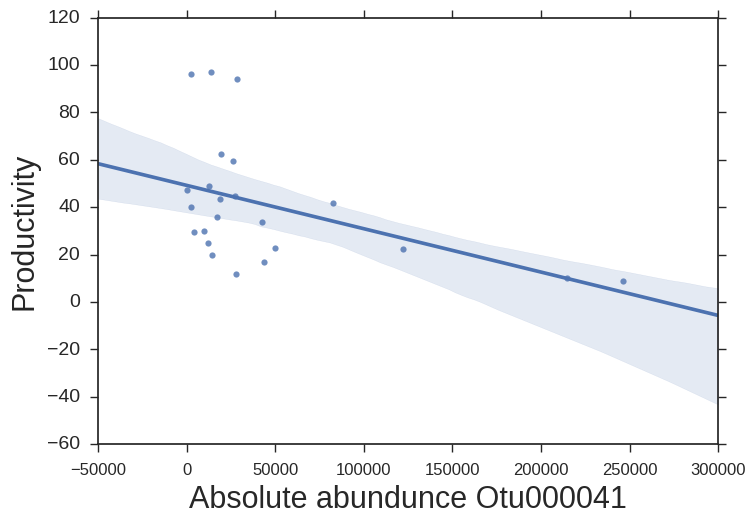

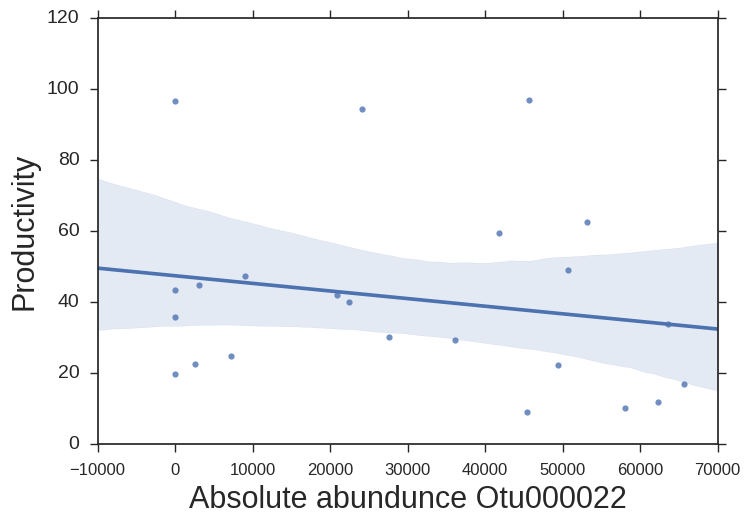

In [31]:
for otu in ['Otu000057','Otu000084','Otu000041','Otu000022']: 
    plt.figure()
    sns.regplot(data_abs.loc[idx_prod, otu], prod)
    plt.xlabel('Absolute abundunce ' + otu, size=22)
    plt.xticks(size=12)
    plt.ylabel('Productivity', size=22)
    plt.yticks(size=14)
    plt.show()

This doesn't show something, but still quite a bit: 
- The productivity samples contain a lot of lower values, and a few higher values. However, these higher values might have a higher (as in, by functioning as an outlier) influence. 
- Some trends are visible. Especially the trend for Otu000022 is interesting (higher abundance results in a lower productivity?)

**MAIN CONCLUSIONS SO FAR: **

- It's a very fruitful approach to go from sequencing data to HNA counts. 
- This means that for a number of OTU's we can predict which of them have high nucleic aicd count. 


- If I **rerun the analysis** using **only the OTU's which are present in the productivity samples**, I still get satisfying results. This means that only those OTU's are considered which are significantly present (>0.0075) in the productivity samples. 
- Using the randomized Lasso, this leaves us with an **optimal of 10 OTU's** to describe the HNA count. 
- However, as there is a linear trend between the HNA counts and the productivity, we can also **tune the randomized Lasso scores in function of the productivity**, by calculating the $R^2$ of the linear regression between the predicted HNA and the productivity. 
- This leaves us with **13 OTU's**. 
- 4 of them have $R^2_{adj}$ > 0 when fitting a linear regression between them. Some preliminary trends can be seen. 
- However, I do think that the productivity samples are too low to perform a full statistical analysis on them. Especially, since I've seen that the experimental error can also be quite big. 